# Reinforcement Learning Project: Maze Extended

We create a maze for an agent to navigate out.

This tutorial is extended from this post.
- https://towardsdatascience.com/hands-on-introduction-to-reinforcement-learning-in-python-da07f7aaca88

However, here, we increased the number of moves that can be implemented
- Initially, there is only horizontal and vertical movement
- Now, we include diagonal movements

Also, we increase the map size to 8 by 8, and make the maze more complicated

# Import Library and Define Possible Actions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Possible Action that can be done by the agent
ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1),
           'UL': (-1,-1), 'UR': (-1,1), 'DL': (1,-1), 'DR': (1,1)}

# Define Maze Class

## Initialize
1. Maze
2. Track movement history
3. Robot position, allowed states, etc

## Methods
1. is_allowed_move: Check if the agent is allowed to move in this direction
2. construct_allowed_states: Check where is the agent allowed to move
3. update_maze: Update the position of the agent
4. is_game_over: Check if the game is ended
5. give_reward: Compute the reward after each actions
6. get_state_and_reward: Get the position and reward after each action

In [2]:
class Maze(object):
    
    def __init__(self):

        #################################################################
        # Defining the Maze
        #################################################################
        self.size = 8
        
        self.maze = np.zeros((self.size, self.size))
        self.maze[0, 0] = 2
        self.maze[1, 5] = 1
        self.maze[0, 2] = 1
        self.maze[3, 6] = 1
        self.maze[4, 4] = 1
        self.maze[7, 4] = 1
        self.maze[2, 0:7] = 1
        self.maze[5, 1:8] = 1
        self.maze[5:7, 2] = 1
        self.maze[3, 2] = 1
        
        #################################################################
        # Keep track of movement history
        #################################################################
        self.movement_history = []
        
        #################################################################
        # Others
        #################################################################
        self.robot_position = (0, 0)     # current robot position
        self.steps = 0                   # contains num steps robot took
        self.allowed_states = None       # for now, this is none
        self.construct_allowed_states()  # not implemented yet
        
        
    #################################################################
    # Check if the agent is allowed to move in a specific direction
    #################################################################
    def is_allowed_move(self, state, action):
        y, x = state
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        
        # Moving off the board
        if ((y < 0) or 
            (x < 0) or 
            (y > self.size-1) or 
            (x > self.size-1)):
             return False
        
        # Moving into start position or empty space
        if self.maze[y, x] == 1:
            return False
        else:
            return True
        
    #################################################################
    # Find all the directions that the agent is allowed to move
    #################################################################
    def construct_allowed_states(self):
        allowed_states = {}
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):
                # Iterate through all valid spaces
                if self.maze[(y,x)] != 1:
                    allowed_states[(y,x)] = []
                    for action in ACTIONS:
                        if self.is_allowed_move((y, x), action):
                            allowed_states[(y,x)].append(action)
                            
        self.allowed_states = allowed_states
        
        
    #################################################################
    # Update the position of the agent within the maze
    #################################################################
    def update_maze(self, action):
        
        y, x = self.robot_position
        
        # Set the current position to empty
        self.maze[y, x] = 0
        
        # Find new position
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        self.robot_position = (y, x)
        self.maze[y, x] = 2
        self.steps += 1
        
        # Keep track of the path the agent moved
        self.movement_history.append(action)

        
    #################################################################
    # If the agent reach the end, ends the game
    #################################################################
    def is_game_over(self):
        if self.robot_position == (self.size-1, self.size-1):
            
            #print('Actions required:', self.steps)
            #print(self.maze)
            #print('Actions:', self.movement_history)
            
            return True
        return False
    
    #################################################################
    # At every step, give reward
    #################################################################
    def give_reward(self):
        if self.robot_position == (self.size-1, self.size-1):
            return 0
        else:
            return -1
        
    #################################################################
    # Update agent position and reward
    #################################################################
    def get_state_and_reward(self):
        return self.robot_position, self.give_reward()

# Define Agent Class

## Initialize
1. State history
2. Alpha - Learning rate
3. Random factor - Exploration rate
4. Reward table G

## Methods
1. init_reward: Generate a random reward table
2. choose_action: From the list of actions allowed, select one action to perform based on G and random factor
3. update_state_history: Update the state and reward
4. learn: Update the reward table G

In [3]:
class Agent(object):
    
    def __init__(self, states, alpha=0.15, random_factor=0.2):
        
        #################################################################
        # Define intial variables
        #################################################################
        self.state_history = [((0, 0), 0)] # State (x,y), reward
        self.alpha = alpha                 # Learning rate
        self.random_factor = random_factor # Exploration rate
        
        #################################################################
        # Initialize reward table
        #################################################################
        self.G = {}
        self.init_reward(states)
        
    #################################################################
    # Initalize reward table with values 0.1-1.0
    #################################################################
    def init_reward(self, states):
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(j,i)] = np.random.uniform(high=1.0, low=0.1)
                
    #################################################################
    # Choose direction to move
    #################################################################
    def choose_action(self, state, allowed_moves):
        next_move = None
        
        # Generate a random number 0 to 1
        n = np.random.random()
        
        # If n < self.random_factor -> Explore -> Go any random move
        if n < self.random_factor:
            next_move = np.random.choice(allowed_moves)
            
        # Eploit -> Go the path with highest expected reward
        else:
            # some really small random number
            maxG = -10e15
            
            # From all the allowed move
            # Find the one with the highest reward and go there
            for action in allowed_moves:
                new_state = tuple([sum(x) for x in zip(state, ACTIONS[action])])
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]
        return next_move
    
    #################################################################
    # Update the state history
    #################################################################
    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

        
    #################################################################
    # Update the reward table
    #################################################################
    def learn(self):
        target = 0

        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

        self.state_history = []
        
        # Reduce exploration rate over time
        self.random_factor -= 10e-5 # decrease random factor each episode of play
        print(self.random_factor)

# Check the inital reward table of the agent

In [4]:
maze = Maze()
robot = Agent(maze.maze, 
              alpha=0.1,         # Learning rate 
              random_factor=0.25 # Exploration rate
             )

robot.G

{(0, 0): 0.7610258577294056,
 (1, 0): 0.654235206364205,
 (2, 0): 0.6426201254369582,
 (3, 0): 0.537496092319211,
 (4, 0): 0.43750093827809033,
 (5, 0): 0.7683793147550404,
 (6, 0): 0.23860800899262513,
 (7, 0): 0.6022387964235331,
 (0, 1): 0.5076564751238181,
 (1, 1): 0.970219310774643,
 (2, 1): 0.560655804763176,
 (3, 1): 0.9849414749609235,
 (4, 1): 0.3334842806129776,
 (5, 1): 0.2145679811502702,
 (6, 1): 0.3712127699447092,
 (7, 1): 0.471526543180245,
 (0, 2): 0.30085769307392946,
 (1, 2): 0.218749010532677,
 (2, 2): 0.7110685055228632,
 (3, 2): 0.5374137727863342,
 (4, 2): 0.4043398667874638,
 (5, 2): 0.802395103761894,
 (6, 2): 0.5489924734260304,
 (7, 2): 0.7047996302130033,
 (0, 3): 0.2864943941013589,
 (1, 3): 0.6851658400590059,
 (2, 3): 0.25542227253122274,
 (3, 3): 0.8182873379658209,
 (4, 3): 0.5223951283746238,
 (5, 3): 0.10571064144671799,
 (6, 3): 0.4002342092462866,
 (7, 3): 0.28364023117654064,
 (0, 4): 0.6099415199541597,
 (1, 4): 0.25328260205886555,
 (2, 4): 0.911

# Run main and let the agent learn from the environment

In [5]:
if __name__ == '__main__':
    
    # Create Maze and Agent
    maze = Maze()
    robot = Agent(maze.maze, 
                  alpha=0.1,         # Learning rate 
                  random_factor=0.25 # Exploration rate
                 )
    size = maze.size
    moveHistory = []

    # Loop for 3000 times
    for i in range(3000):
        print('\nLoop:', i+1)

        # Reinitialize the maze
        maze = Maze()
        
        # Conduct an action per turn
        while not maze.is_game_over():
            # Get the current state
            state, _ = maze.get_state_and_reward()
            
            # choose an action (explore or exploit)
            action = robot.choose_action(state, maze.allowed_states[state])
            
            # Update the maze according to the action
            maze.update_maze(action)
            
            # Get the new state and reward
            state, reward = maze.get_state_and_reward()
            
            # Update the robot memory with state and reward
            robot.update_state_history(state, reward)
            
            if maze.steps > 1000:
                # End the robot if it takes too long to find the goal
                # Set position to (5,5) to end the game
                maze.robot_position = (size-1,size-1)
        
        # Robot should learn after every episode
        robot.learn()
        
        # Get a history of number of steps taken to plot later
        moveHistory.append(maze.steps)


Loop: 1
0.2499

Loop: 2
0.24980000000000002

Loop: 3
0.24970000000000003

Loop: 4
0.24960000000000004

Loop: 5
0.24950000000000006

Loop: 6
0.24940000000000007

Loop: 7
0.24930000000000008

Loop: 8
0.2492000000000001

Loop: 9
0.2491000000000001

Loop: 10
0.2490000000000001

Loop: 11
0.24890000000000012

Loop: 12
0.24880000000000013

Loop: 13
0.24870000000000014

Loop: 14
0.24860000000000015

Loop: 15
0.24850000000000017

Loop: 16
0.24840000000000018

Loop: 17
0.2483000000000002

Loop: 18
0.2482000000000002

Loop: 19
0.2481000000000002

Loop: 20
0.24800000000000022

Loop: 21
0.24790000000000023

Loop: 22
0.24780000000000024

Loop: 23
0.24770000000000025

Loop: 24
0.24760000000000026

Loop: 25
0.24750000000000028

Loop: 26
0.2474000000000003

Loop: 27
0.2473000000000003

Loop: 28
0.2472000000000003

Loop: 29
0.24710000000000032

Loop: 30
0.24700000000000033

Loop: 31
0.24690000000000034

Loop: 32
0.24680000000000035

Loop: 33
0.24670000000000036

Loop: 34
0.24660000000000037

Loop: 35
0

Loop: 490
0.2010000000000054

Loop: 491
0.2009000000000054

Loop: 492
0.20080000000000542

Loop: 493
0.20070000000000543

Loop: 494
0.20060000000000544

Loop: 495
0.20050000000000545

Loop: 496
0.20040000000000546

Loop: 497
0.20030000000000547

Loop: 498
0.20020000000000548

Loop: 499
0.2001000000000055

Loop: 500
0.2000000000000055

Loop: 501
0.19990000000000552

Loop: 502
0.19980000000000553

Loop: 503
0.19970000000000554

Loop: 504
0.19960000000000555

Loop: 505
0.19950000000000556

Loop: 506
0.19940000000000557

Loop: 507
0.19930000000000558

Loop: 508
0.1992000000000056

Loop: 509
0.1991000000000056

Loop: 510
0.19900000000000562

Loop: 511
0.19890000000000563

Loop: 512
0.19880000000000564

Loop: 513
0.19870000000000565

Loop: 514
0.19860000000000566

Loop: 515
0.19850000000000567

Loop: 516
0.19840000000000568

Loop: 517
0.1983000000000057

Loop: 518
0.1982000000000057

Loop: 519
0.19810000000000572

Loop: 520
0.19800000000000573

Loop: 521
0.19790000000000574

Loop: 522
0.1978

0.1727000000000085

Loop: 774
0.17260000000000852

Loop: 775
0.17250000000000854

Loop: 776
0.17240000000000855

Loop: 777
0.17230000000000856

Loop: 778
0.17220000000000857

Loop: 779
0.17210000000000858

Loop: 780
0.1720000000000086

Loop: 781
0.1719000000000086

Loop: 782
0.1718000000000086

Loop: 783
0.17170000000000862

Loop: 784
0.17160000000000863

Loop: 785
0.17150000000000865

Loop: 786
0.17140000000000866

Loop: 787
0.17130000000000867

Loop: 788
0.17120000000000868

Loop: 789
0.1711000000000087

Loop: 790
0.1710000000000087

Loop: 791
0.1709000000000087

Loop: 792
0.17080000000000872

Loop: 793
0.17070000000000873

Loop: 794
0.17060000000000874

Loop: 795
0.17050000000000876

Loop: 796
0.17040000000000877

Loop: 797
0.17030000000000878

Loop: 798
0.1702000000000088

Loop: 799
0.1701000000000088

Loop: 800
0.1700000000000088

Loop: 801
0.16990000000000882

Loop: 802
0.16980000000000883

Loop: 803
0.16970000000000884

Loop: 804
0.16960000000000885

Loop: 805
0.1695000000000088

Loop: 1075
0.14250000000001184

Loop: 1076
0.14240000000001185

Loop: 1077
0.14230000000001186

Loop: 1078
0.14220000000001187

Loop: 1079
0.14210000000001188

Loop: 1080
0.1420000000000119

Loop: 1081
0.1419000000000119

Loop: 1082
0.14180000000001192

Loop: 1083
0.14170000000001193

Loop: 1084
0.14160000000001194

Loop: 1085
0.14150000000001195

Loop: 1086
0.14140000000001196

Loop: 1087
0.14130000000001197

Loop: 1088
0.14120000000001198

Loop: 1089
0.141100000000012

Loop: 1090
0.141000000000012

Loop: 1091
0.14090000000001202

Loop: 1092
0.14080000000001203

Loop: 1093
0.14070000000001204

Loop: 1094
0.14060000000001205

Loop: 1095
0.14050000000001206

Loop: 1096
0.14040000000001207

Loop: 1097
0.14030000000001208

Loop: 1098
0.1402000000000121

Loop: 1099
0.1401000000000121

Loop: 1100
0.14000000000001211

Loop: 1101
0.13990000000001213

Loop: 1102
0.13980000000001214

Loop: 1103
0.13970000000001215

Loop: 1104
0.13960000000001216

Loop: 1105
0.13950000000001217

Loop: 1106
0.139

Loop: 1372
0.11280000000001342

Loop: 1373
0.11270000000001341

Loop: 1374
0.11260000000001341

Loop: 1375
0.11250000000001341

Loop: 1376
0.1124000000000134

Loop: 1377
0.1123000000000134

Loop: 1378
0.1122000000000134

Loop: 1379
0.1121000000000134

Loop: 1380
0.1120000000000134

Loop: 1381
0.11190000000001339

Loop: 1382
0.11180000000001339

Loop: 1383
0.11170000000001339

Loop: 1384
0.11160000000001338

Loop: 1385
0.11150000000001338

Loop: 1386
0.11140000000001338

Loop: 1387
0.11130000000001337

Loop: 1388
0.11120000000001337

Loop: 1389
0.11110000000001337

Loop: 1390
0.11100000000001337

Loop: 1391
0.11090000000001336

Loop: 1392
0.11080000000001336

Loop: 1393
0.11070000000001336

Loop: 1394
0.11060000000001335

Loop: 1395
0.11050000000001335

Loop: 1396
0.11040000000001335

Loop: 1397
0.11030000000001335

Loop: 1398
0.11020000000001334

Loop: 1399
0.11010000000001334

Loop: 1400
0.11000000000001334

Loop: 1401
0.10990000000001333

Loop: 1402
0.10980000000001333

Loop: 1403
0.

0.08230000000001254

Loop: 1678
0.08220000000001254

Loop: 1679
0.08210000000001254

Loop: 1680
0.08200000000001254

Loop: 1681
0.08190000000001253

Loop: 1682
0.08180000000001253

Loop: 1683
0.08170000000001253

Loop: 1684
0.08160000000001252

Loop: 1685
0.08150000000001252

Loop: 1686
0.08140000000001252

Loop: 1687
0.08130000000001252

Loop: 1688
0.08120000000001251

Loop: 1689
0.08110000000001251

Loop: 1690
0.0810000000000125

Loop: 1691
0.0809000000000125

Loop: 1692
0.0808000000000125

Loop: 1693
0.0807000000000125

Loop: 1694
0.0806000000000125

Loop: 1695
0.08050000000001249

Loop: 1696
0.08040000000001249

Loop: 1697
0.08030000000001249

Loop: 1698
0.08020000000001248

Loop: 1699
0.08010000000001248

Loop: 1700
0.08000000000001248

Loop: 1701
0.07990000000001247

Loop: 1702
0.07980000000001247

Loop: 1703
0.07970000000001247

Loop: 1704
0.07960000000001247

Loop: 1705
0.07950000000001246

Loop: 1706
0.07940000000001246

Loop: 1707
0.07930000000001246

Loop: 1708
0.07920000000

Loop: 2047
0.045300000000011484

Loop: 2048
0.04520000000001148

Loop: 2049
0.04510000000001148

Loop: 2050
0.045000000000011475

Loop: 2051
0.04490000000001147

Loop: 2052
0.04480000000001147

Loop: 2053
0.04470000000001147

Loop: 2054
0.044600000000011464

Loop: 2055
0.04450000000001146

Loop: 2056
0.04440000000001146

Loop: 2057
0.044300000000011455

Loop: 2058
0.04420000000001145

Loop: 2059
0.04410000000001145

Loop: 2060
0.04400000000001145

Loop: 2061
0.043900000000011444

Loop: 2062
0.04380000000001144

Loop: 2063
0.04370000000001144

Loop: 2064
0.043600000000011435

Loop: 2065
0.04350000000001143

Loop: 2066
0.04340000000001143

Loop: 2067
0.04330000000001143

Loop: 2068
0.043200000000011424

Loop: 2069
0.04310000000001142

Loop: 2070
0.04300000000001142

Loop: 2071
0.042900000000011415

Loop: 2072
0.04280000000001141

Loop: 2073
0.04270000000001141

Loop: 2074
0.042600000000011407

Loop: 2075
0.042500000000011404

Loop: 2076
0.0424000000000114

Loop: 2077
0.0423000000000114



Loop: 2484
0.0016000000000112174

Loop: 2485
0.0015000000000112174

Loop: 2486
0.0014000000000112174

Loop: 2487
0.0013000000000112173

Loop: 2488
0.0012000000000112173

Loop: 2489
0.0011000000000112172

Loop: 2490
0.0010000000000112172

Loop: 2491
0.0009000000000112171

Loop: 2492
0.0008000000000112171

Loop: 2493
0.000700000000011217

Loop: 2494
0.000600000000011217

Loop: 2495
0.000500000000011217

Loop: 2496
0.00040000000001121696

Loop: 2497
0.00030000000001121697

Loop: 2498
0.00020000000001121698

Loop: 2499
0.00010000000001121697

Loop: 2500
1.1216965941154844e-14

Loop: 2501
-9.999999998878304e-05

Loop: 2502
-0.00019999999998878304

Loop: 2503
-0.00029999999998878303

Loop: 2504
-0.000399999999988783

Loop: 2505
-0.0004999999999887831

Loop: 2506
-0.0005999999999887831

Loop: 2507
-0.0006999999999887832

Loop: 2508
-0.0007999999999887832

Loop: 2509
-0.0008999999999887833

Loop: 2510
-0.0009999999999887833

Loop: 2511
-0.0010999999999887833

Loop: 2512
-0.0011999999999887834


Loop: 2984
-0.04839999999998914

Loop: 2985
-0.04849999999998914

Loop: 2986
-0.048599999999989145

Loop: 2987
-0.04869999999998915

Loop: 2988
-0.04879999999998915

Loop: 2989
-0.048899999999989154

Loop: 2990
-0.048999999999989156

Loop: 2991
-0.04909999999998916

Loop: 2992
-0.04919999999998916

Loop: 2993
-0.049299999999989165

Loop: 2994
-0.04939999999998917

Loop: 2995
-0.04949999999998917

Loop: 2996
-0.049599999999989174

Loop: 2997
-0.049699999999989176

Loop: 2998
-0.04979999999998918

Loop: 2999
-0.04989999999998918

Loop: 3000
-0.049999999999989185


# Plot Steps Rquired before game over or terminated

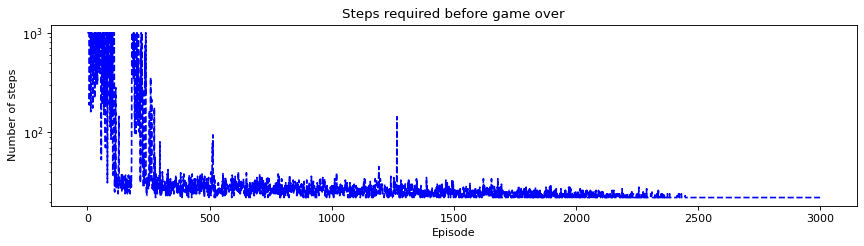

In [6]:
plt.figure(figsize=(13, 3), dpi=80)
plt.semilogy(moveHistory, "b--")
plt.title('Steps required before game over')
plt.ylabel('Number of steps')
plt.xlabel('Episode')
plt.show()

# Check the updated reward table of the agent

In [7]:
robot.G

{(0, 0): -25.812042375000782,
 (1, 0): -23.63285108313968,
 (2, 0): 0.4580550991314448,
 (3, 0): -8.633472426522356,
 (4, 0): -7.174882023366906,
 (5, 0): -6.0000000000000036,
 (6, 0): -6.405814013634054,
 (7, 0): -6.508570323210565,
 (0, 1): -21.555337832297326,
 (1, 1): -20.000000000000014,
 (2, 1): 0.8319671692423818,
 (3, 1): -8.41248816025603,
 (4, 1): -7.0000000000000036,
 (5, 1): 0.6465318044478899,
 (6, 1): -5.0000000000000036,
 (7, 1): -5.184003635128491,
 (0, 2): 0.5559060571989242,
 (1, 2): -19.000000000000014,
 (2, 2): 0.4482987905421406,
 (3, 2): 0.27928919070454156,
 (4, 2): -8.000000000000007,
 (5, 2): 0.17458068251867825,
 (6, 2): 0.6458211274451525,
 (7, 2): -4.0000000000000036,
 (0, 3): -18.000000000000014,
 (1, 3): -19.154725952039467,
 (2, 3): 0.27741298573257106,
 (3, 3): -9.61440879488633,
 (4, 3): -9.000000000000007,
 (5, 3): 0.5314644001052479,
 (6, 3): -3.0000000000000018,
 (7, 3): -3.5025093142948314,
 (0, 4): -18.263288057094016,
 (1, 4): -17.000000000000014,

# We visualize the reward table across the environment (x,y)
We set the "walls" to be -10000

Note:
- Only the goal is 0
- The other path will always be a negative value

In [8]:
matrix_G = np.zeros((size,size))

for i in robot.G:
    x, y = i
    reward = robot.G[i]
    matrix_G[x,y] = reward

matrix_G = np.round(matrix_G,3)
matrix_G[matrix_G>0] = -10000

np.set_printoptions(suppress=True)
print(matrix_G)

[[   -25.812    -21.555 -10000.       -18.       -18.263    -16.
     -17.19     -18.344]
 [   -23.633    -20.       -19.       -19.155    -17.    -10000.
     -15.       -15.66 ]
 [-10000.    -10000.    -10000.    -10000.    -10000.    -10000.
  -10000.       -14.   ]
 [    -8.633     -8.412 -10000.        -9.614    -10.       -11.
  -10000.       -13.   ]
 [    -7.175     -7.        -8.        -9.    -10000.       -11.771
     -12.       -13.659]
 [    -6.    -10000.    -10000.    -10000.    -10000.    -10000.
  -10000.    -10000.   ]
 [    -6.406     -5.    -10000.        -3.        -2.        -1.185
      -0.255     -0.133]
 [    -6.509     -5.184     -4.        -3.503 -10000.        -1.
      -0.         0.   ]]


# Print the best action set

In [9]:
maze.movement_history

['DR',
 'R',
 'UR',
 'DR',
 'UR',
 'DR',
 'DR',
 'D',
 'DL',
 'UL',
 'L',
 'DL',
 'L',
 'L',
 'DL',
 'DR',
 'DR',
 'UR',
 'R',
 'DR',
 'R',
 'R']

# Plot the reward table as a color map

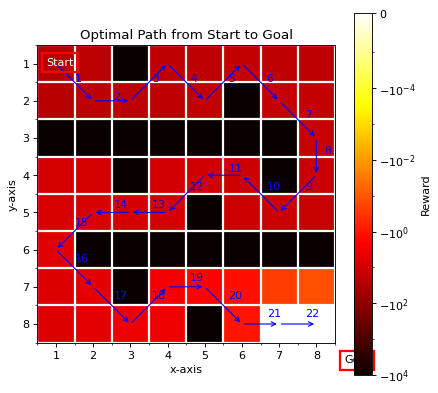

In [10]:
#################################################################
# Compute parameters to plot log scale color bar
#################################################################
logthresh = 5
vmin = np.min(matrix_G)
vmax = np.max([np.max(matrix_G), 1])
maxlog=int(np.ceil(np.log10(vmax) ))
minlog=int(np.ceil(np.log10(-vmin) ))

#################################################################
# Plot color map
#################################################################
plt.figure(figsize=(6, 6), dpi=80)
plt.imshow(matrix_G, 
           cmap='hot', 
           #interpolation='nearest',
           norm=matplotlib.colors.SymLogNorm(10**-logthresh)
          )

#################################################################
# Plot action path from start to goal
#################################################################
action_list = maze.movement_history

start_x = 0
start_y = 0
for i, action in enumerate(action_list):
    end_x = start_x + ACTIONS[action][0]
    end_y = start_y + ACTIONS[action][1]
    
    plt.annotate('', 
                 xytext=(end_y, end_x),
                 xy=(start_y, start_x), 
                 arrowprops=dict(arrowstyle="<-", color='blue'))
    
    x_mid = (start_x+end_x)/2
    y_mid = (start_y+end_y)/2
    
    plt.annotate(i+1, 
                 xytext=(y_mid, x_mid),
                 xy=(y_mid, x_mid), 
                 color='blue',
                 textcoords='offset points')
    
    start_x = end_x
    start_y = end_y

plt.text(size-0.25, size+0.05, 'Goal', 
         bbox=dict(fill=False, edgecolor='red', linewidth=2))
plt.text(-0.25, 0.05, 'Start', color='white', 
         bbox=dict(fill=False, edgecolor='red', linewidth=2))
    
#################################################################
# Generate logarithmic ticks 
#################################################################
tick_locations=([-(10**x) for x in range(minlog,-logthresh-1,-2)]
                +[0.0]
                +[(10**x) for x in range(-logthresh,maxlog+1,2)])

#################################################################
# Generating grid for clearer illustration
#################################################################
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, size, 1))
ax.set_yticks(np.arange(0, size, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1))
ax.set_yticklabels(np.arange(1, size+1, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, size, 1), minor=True)
ax.set_yticks(np.arange(-.5, size, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

#################################################################
# Add description
#################################################################
plt.title('Optimal Path from Start to Goal')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

cbar = plt.colorbar(ticks=tick_locations)
cbar.set_label('Reward')

plt.show()